# Load data

In [69]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


In [2]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Training dataset creation

### Input data: filtered SGS heat flux

In [3]:
Qstar = xr.open_dataset(
    "gs://leap-persistent/panalluri/HF_star.zarr", engine="zarr", chunks={}
)
Qstar

<xarray.Dataset> Size: 14GB
Dimensions:   (time: 365, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>

### Choose same regions as Abigail

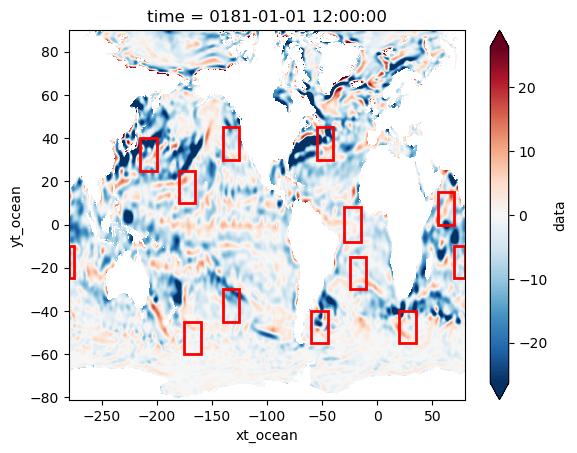

In [4]:
import matplotlib.pyplot as plt

# Example plot with Qstar.data
Qstar.data.isel(time=0).plot(robust=True)

# Define multiple latitude and longitude ranges
# (conversion to ds coords by hand for now)
boxes = [
    (30, 45, -40, -55),  # gulf stream = (30, 45, -60, -45)
    (-30, -15, -25, -10),  # south atlantic = (-30, -15, -25, -10)
    (-8, 8, -30, -15), # equator atlantic = (-8, 8, -30, -15)    
    (-55, -40, -60, -45), # malvinas current = (-55, -40, -60, -45)
    (30, 45, -140, -125), # california current = (30, 45, -140, -125)
    (-45, -30, -140, -125), # south pacific = (-45, -30, -140, -125)
    (25, 40, -215, -200), # kuroshio extension = (25, 40, 145, 160)
    (10, 25, -180, -165), # north pacific = (10, 25, -180, -165)
    (-60, -45, -175, -160), # southern ocean, new zealand = (-60, -45, -175, -160)
    (-55, -40, 20, 35), # agulhas current = (-55, -40, 20, 35)
    (-25, -10, 70, 79.95), # indian ocean (west chunk) = (-25, -10, 70, 85)
    (-25, -10, -279.95, -275), # indian ocean (east chunk) = (-25, -10, 70, 85)
    (0, 15, 55, 70) # arabian sea = (0, 15, 55, 70)
]

for lat_min, lat_max, lon_min, lon_max in boxes:

    # Draw the box on the plot
    plt.gca().add_patch(
        plt.Rectangle(
            (lon_min, lat_min),  # (x, y) start point
            lon_max - lon_min,  # width
            lat_max - lat_min,  # height
            fill=False,          # don't fill the box
            edgecolor='red',     # color of the box
            linewidth=2
        )
    )

# Show the plot
plt.show()


### Construct Q_star input and output data set for each region

In [13]:
# data samples of regions in the ocean
# choose just one region
ds_Qstar_temp = Qstar.sel(yt_ocean=slice(-30, -15), xt_ocean=slice(-25, -10)) # South Atlantic
ds_Qstar = ds_Qstar_temp.isel(time=slice(0,365))
ds_Qstar # high res SGS heat flux

<xarray.Dataset> Size: 36MB
Dimensions:   (time: 365, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>

In [14]:
print("Filtering model")
Q_out = filter_inputs_dataset(ds_Qstar, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
Q_out # low res filtered heat flux

Filtering model


<xarray.Dataset> Size: 36MB
Dimensions:   (time: 365, xt_ocean: 150, yt_ocean: 163)
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

### Construct input data: u_rel, v_rel, q_ref, t_ref, sst

u_rel = relative u_dir velocity b/n ocean and atmos \
v_rel = relative v_dir velocity b/n ocean and atmos \
q_ref = specific humidity at 2m in atmos \
t_ref = temperature at 2m in atmos \
sst = sea surface temp

In [17]:
ds_in = ds_merged.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

print("Filtering model")
ds_temp = ds_in.isel(time=slice(0,365))
ds_out = filter_inputs_dataset(ds_temp, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')

ds_lowRes = ds_out.sel(yt_ocean=slice(-30, -15), xt_ocean=slice(-25, -10)) # South Atlantic
ds_lowRes

Filtering model


<xarray.Dataset> Size: 393MB
Dimensions:       (time: 365, xt_ocean: 150, yt_ocean: 163)
Coordinates:
  * time          (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean      (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

### Organize training/testing data into batches

#### Timing steps in data processing

#### Set up parallel processing

In [47]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=2) #default: n_workers=4, threads_per_worker=1
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/panalluri/proxy/8787/status,
Dashboard: /user/panalluri/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36155,Workers: 4
Dashboard: /user/panalluri/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:40085,Total threads: 2
Dashboard: /user/panalluri/proxy/38181/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:38875,


2024-09-30 19:40:24,328 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='leap.2i2c.cloud', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/tornado/websocket.py", line 938, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/tornado/web.py", line 3301, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


### Data processing

In [48]:
# Set number of time samples
time_training = ds_lowRes['time'][::30][:-4]
time_len = len(time_training)

# Define the dimensions
xt_len = len(ds_lowRes.xt_ocean) 
yt_len = len(ds_lowRes.yt_ocean) 

# Extract needed data
urel_data = ds_lowRes.u_relative.sel(time=time_training).values
vrel_data = ds_lowRes.v_relative.sel(time=time_training).values
sst_data = ds_lowRes.surface_temp.sel(time=time_training).values
tref_data = ds_lowRes.t_ref.sel(time=time_training).values
qref_data = ds_lowRes.q_ref.sel(time=time_training).values
Qstar_data = ds_Qstar.data.sel(time=time_training).values
Qout_data = Q_out.data.sel(time=time_training).values

# Define coordinates
xt_ocean = ds_lowRes.xt_ocean
yt_ocean = ds_lowRes.yt_ocean

# Preallocate the Dataset
ds_training = xr.Dataset(
    {
        'u_rel': (['time', 'yt_ocean', 'xt_ocean'], urel_data),  # Preallocated NaN array
        'v_rel': (['time', 'yt_ocean', 'xt_ocean'], vrel_data),      
        't_ref': (['time', 'yt_ocean', 'xt_ocean'], tref_data),
        'q_ref': (['time', 'yt_ocean', 'xt_ocean'], qref_data),
        'sst': (['time', 'yt_ocean', 'xt_ocean'], sst_data),
        'Q_star': (['time', 'yt_ocean', 'xt_ocean'], Qstar_data),
        'Q_out': (['time', 'yt_ocean', 'xt_ocean'], Qout_data)
    },
    coords={
        'time': time_training,
        'xt_ocean': xt_ocean,
        'yt_ocean': yt_ocean
    }
)

ds_training

<xarray.Dataset> Size: 11MB
Dimensions:   (time: 9, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 72B 0181-01-01 12:00:00 ... 0181-08-29 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    u_rel     (time, yt_ocean, xt_ocean) float64 2MB -0.9651 -1.036 ... -7.107
    v_rel     (time, yt_ocean, xt_ocean) float64 2MB -6.33 -6.322 ... 1.821
    t_ref     (time, yt_ocean, xt_ocean) float64 2MB 293.4 293.4 ... 291.3 291.3
    q_ref     (time, yt_ocean, xt_ocean) float64 2MB 0.01364 0.01363 ... 0.0102
    sst       (time, yt_ocean, xt_ocean) float64 2MB 293.3 293.3 ... 293.1 293.1
    Q_star    (time, yt_ocean, xt_ocean) float32 880kB 2.005 2.107 ... 0.6062
    Q_out     (time, yt_ocean, xt_ocean) float64 2MB -1.032 -0.9116 ... -2.053

In [49]:
# save to bucket
ds_training.to_zarr("gs://leap-persistent/panalluri/ds_trainingData_southAtlantic.zarr")

In [50]:
# Set number of time samples
time_testing = ds_lowRes['time'][::30][-4:]

# Create empty arrays (with NaNs) for preallocation
urel_data = ds_lowRes.u_relative.sel(time=time_testing).values
vrel_data = ds_lowRes.v_relative.sel(time=time_testing).values
sst_data = ds_lowRes.surface_temp.sel(time=time_testing).values
tref_data = ds_lowRes.t_ref.sel(time=time_testing).values
qref_data = ds_lowRes.q_ref.sel(time=time_testing).values
Qstar_data = ds_Qstar.data.sel(time=time_testing).values
Qout_data = Q_out.data.sel(time=time_testing).values

# Preallocate the Dataset
ds_testing = xr.Dataset(
    {
        'u_rel': (['time', 'yt_ocean', 'xt_ocean'], urel_data),  # Preallocated NaN array
        'v_rel': (['time', 'yt_ocean', 'xt_ocean'], vrel_data),      
        't_ref': (['time', 'yt_ocean', 'xt_ocean'], tref_data),
        'q_ref': (['time', 'yt_ocean', 'xt_ocean'], qref_data),
        'sst': (['time', 'yt_ocean', 'xt_ocean'], sst_data),
        'Q_star': (['time', 'yt_ocean', 'xt_ocean'], Qstar_data),
        'Q_out': (['time', 'yt_ocean', 'xt_ocean'], Qout_data)
    },
    coords={
        'time': time_testing,
        'xt_ocean': xt_ocean,
        'yt_ocean': yt_ocean
    }
)

ds_testing

<xarray.Dataset> Size: 5MB
Dimensions:   (time: 4, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 32B 0181-09-28 12:00:00 ... 0181-12-27 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    u_rel     (time, yt_ocean, xt_ocean) float64 782kB 0.09512 ... -6.891
    v_rel     (time, yt_ocean, xt_ocean) float64 782kB -2.708 -2.73 ... 4.335
    t_ref     (time, yt_ocean, xt_ocean) float64 782kB 288.6 288.6 ... 294.3
    q_ref     (time, yt_ocean, xt_ocean) float64 782kB 0.008611 ... 0.01347
    sst       (time, yt_ocean, xt_ocean) float64 782kB 289.9 289.9 ... 295.4
    Q_star    (time, yt_ocean, xt_ocean) float32 391kB -2.237 -2.368 ... -1.189
    Q_out     (time, yt_ocean, xt_ocean) float64 782kB -2.979 -3.049 ... 0.9041

In [53]:
# save to bucket
ds_testing.to_zarr("gs://leap-persistent/panalluri/ds_testingData_southAtlantic.zarr")

#### Convert to torch tensor

In [55]:
# Create a 4D tensor using all variables from ds_testing
# First, extract the values from the dataset
u_rel = ds_training['u_rel'].values
v_rel = ds_training['v_rel'].values
t_ref = ds_training['t_ref'].values
q_ref = ds_training['q_ref'].values
sst = ds_training['sst'].values
Q_star = ds_training['Q_star'].values
Q_out = ds_training['Q_out'].values

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
training_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, t_ref, q_ref, sst, Q_star, Q_out], axis=3))

# Now data_array is a 4D tensor
training_NN_inputs


tensor([[[[-9.6512e-01, -6.3304e+00,  2.9336e+02,  ...,  2.9329e+02,
            2.0054e+00, -1.0321e+00],
          [-1.0361e+00, -6.3221e+00,  2.9337e+02,  ...,  2.9329e+02,
            2.1065e+00, -9.1159e-01],
          [-1.1081e+00, -6.3105e+00,  2.9337e+02,  ...,  2.9330e+02,
            2.2065e+00, -7.9348e-01],
          ...,
          [-6.0987e+00,  1.2395e+00,  2.9200e+02,  ...,  2.9379e+02,
           -1.1035e+01, -1.4039e+00],
          [-6.1073e+00,  1.2843e+00,  2.9200e+02,  ...,  2.9378e+02,
           -1.0932e+01, -1.2787e+00],
          [-6.1152e+00,  1.3286e+00,  2.9199e+02,  ...,  2.9378e+02,
           -1.0812e+01, -1.1546e+00]],

         [[-9.2848e-01, -6.3078e+00,  2.9341e+02,  ...,  2.9335e+02,
            2.0596e+00, -9.5882e-01],
          [-9.9952e-01, -6.2975e+00,  2.9341e+02,  ...,  2.9335e+02,
            2.1590e+00, -8.3501e-01],
          [-1.0716e+00, -6.2841e+00,  2.9341e+02,  ...,  2.9335e+02,
            2.2578e+00, -7.1359e-01],
          ...,
     

In [56]:
# Create a 4D tensor using all variables from ds_testing
# First, extract the values from the dataset
u_rel = ds_testing['u_rel'].values
v_rel = ds_testing['v_rel'].values
t_ref = ds_testing['t_ref'].values
q_ref = ds_testing['q_ref'].values
sst = ds_testing['sst'].values
Q_star = ds_testing['Q_star'].values
Q_out = ds_testing['Q_out'].values

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
testing_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, t_ref, q_ref, sst, Q_star, Q_out], axis=3))

# Now data_array is a 4D tensor
testing_NN_inputs


tensor([[[[ 9.5125e-02, -2.7079e+00,  2.8859e+02,  ...,  2.8990e+02,
           -2.2367e+00, -2.9795e+00],
          [ 7.7923e-02, -2.7298e+00,  2.8857e+02,  ...,  2.8989e+02,
           -2.3679e+00, -3.0489e+00],
          [ 6.0952e-02, -2.7519e+00,  2.8855e+02,  ...,  2.8988e+02,
           -2.5164e+00, -3.1185e+00],
          ...,
          [-2.8880e+00,  9.1772e-02,  2.8700e+02,  ...,  2.8887e+02,
           -2.1455e+00, -2.7768e+00],
          [-2.9163e+00,  1.3600e-01,  2.8699e+02,  ...,  2.8886e+02,
           -1.9782e+00, -2.8430e+00],
          [-2.9451e+00,  1.7983e-01,  2.8698e+02,  ...,  2.8885e+02,
           -1.8071e+00, -2.9108e+00]],

         [[-1.9902e-02, -2.6774e+00,  2.8861e+02,  ...,  2.8994e+02,
           -2.3337e+00, -3.0368e+00],
          [-3.6797e-02, -2.6983e+00,  2.8859e+02,  ...,  2.8994e+02,
           -2.4636e+00, -3.1062e+00],
          [-5.3434e-02, -2.7196e+00,  2.8857e+02,  ...,  2.8993e+02,
           -2.6105e+00, -3.1757e+00],
          ...,
     

## NN architecture setup

In [67]:
image_height = training_NN_inputs.shape[1]
image_width = training_NN_inputs.shape[2]
output_channels = 3 #RGB output

In [68]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1)  # Adjust input channels to 6
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (image_height // 8) * (image_width // 8), 128)  # Adjust for image dimensions
        self.fc2 = nn.Linear(128, output_channels * image_height * image_width)  # Adjust output shape

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv3(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, output_channels, image_height, image_width)  # Reshape to output image
        return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=23040, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=73350, bias=True)
)


In [70]:
class OceanDataset(Dataset):
    def __init__(self, input_images, output_images, transform=None):
        self.input_images = input_images
        self.output_images = output_images
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        x = self.input_images[idx]
        y = self.output_images[idx]

        if self.transform:
            x = self.transform(x)

        return x, y


In [71]:
criterion = nn.MSELoss()  # Use appropriate loss for your task
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10  # Adjust as necessary

for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


In [19]:
#torch.save(model.state_dict(), 'leap-persistent/panalluri/airSeaNN_temporal.pth')

In [20]:
#torch.save(model, 'leap-persistent/panalluri/airSeaNN_temporal_wholeModel.pth')